# 進め・止まれと BLE で指示をする、交通信号機の聲を聴く

In [83]:
# 記事では書いていない、matplotlibの日本語処理用

import matplotlib.pyplot as plt

#plt.rcParams['font.family']='Hiragino Sans'# フォント設定
#plt.rcParams['font.weight']='bold' # 太さ
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 20
plt.rcParams["figure.figsize"]=15,15

## Company Identifiersを取得しておく

In [100]:
import requests, yaml, re

# URLからYAMLデータを取得
url = "https://bitbucket.org/bluetooth-SIG/public/raw/adc9c005881e2ccd2d8dc5055f657a18622159f5/assigned_numbers/company_identifiers/company_identifiers.yaml"
response = requests.get(url)
# 制御文字（U+0000～U+001F、U+007F～U+009F）をスペースに置換
cleaned_text = re.sub(r'[\x00-\x08\x0B-\x0C\x0E-\x1F\x7F-\x9F]', ' ', response.text)
# {16進数表記のid: name}形式の辞書を生成
company_dict = {f"0x{entry["value"]:04X}":entry["name"] \
              for entry in yaml.safe_load(cleaned_text)["company_identifiers"]}

In [101]:
company_dict

{'0x0EE0': 'MAERSK CONTAINER INDUSTRY A/S',
 '0x0EDF': 'Dynaudio A/S',
 '0x0EDE': 'Sony Honda Mobility Inc.',
 '0x0EDD': 'Ceridwen Limited',
 '0x0EDC': 'Shenzhen Zoqin Technology Co., Ltd.',
 '0x0EDB': 'ShenZhen BoYiChuangXin',
 '0x0EDA': 'Kodira GmbH',
 '0x0ED9': 'Overhead Door Corporation',
 '0x0ED8': 'DORAN MFG. LLC',
 '0x0ED7': 'CS INSTRUMENTS GmbH & Co.KG',
 '0x0ED6': 'Quintessential Design, Inc.',
 '0x0ED5': 'Relish Technologies Limited',
 '0x0ED4': 'Goerdyna Group Co., Ltd',
 '0x0ED3': 'Lichens Innovation inc.',
 '0x0ED2': 'SHENZHEN BESTWAY ELECTRONICS CO.,LTD',
 '0x0ED1': 'VINYL MATT MEDIA LIMITED',
 '0x0ED0': 'Gibson, Inc.',
 '0x0ECF': 'GGEC America, Inc.',
 '0x0ECE': 'Guangzhou Honor Microelectronic Co.,Ltd.',
 '0x0ECD': 'Nature Inc.',
 '0x0ECC': 'Shenzhen NEOECO Technology Co., Ltd.',
 '0x0ECB': 'Zhong Shan City Richsound Electronic Industrial Ltd.',
 '0x0ECA': 'NexRev LLC',
 '0x0EC9': 'NeuroPace Inc',
 '0x0EC8': 'Codie LLC',
 '0x0EC7': 'Canyon Bicycles GmbH',
 '0x0EC6': 'Au

In [3]:
# 取得したCompany Identifiers保存したり読み込む場合
import pickle

# 読み込み
#with open('company_dict', mode='rb') as f:
#    company_dict = pickle.load(f)

# 書き込み
with open("company_dict", mode="wb") as f:
    pickle.dump(company_dict, f)

company_dict

{'0x0EE0': 'MAERSK CONTAINER INDUSTRY A/S',
 '0x0EDF': 'Dynaudio A/S',
 '0x0EDE': 'Sony Honda Mobility Inc.',
 '0x0EDD': 'Ceridwen Limited',
 '0x0EDC': 'Shenzhen Zoqin Technology Co., Ltd.',
 '0x0EDB': 'ShenZhen BoYiChuangXin',
 '0x0EDA': 'Kodira GmbH',
 '0x0ED9': 'Overhead Door Corporation',
 '0x0ED8': 'DORAN MFG. LLC',
 '0x0ED7': 'CS INSTRUMENTS GmbH & Co.KG',
 '0x0ED6': 'Quintessential Design, Inc.',
 '0x0ED5': 'Relish Technologies Limited',
 '0x0ED4': 'Goerdyna Group Co., Ltd',
 '0x0ED3': 'Lichens Innovation inc.',
 '0x0ED2': 'SHENZHEN BESTWAY ELECTRONICS CO.,LTD',
 '0x0ED1': 'VINYL MATT MEDIA LIMITED',
 '0x0ED0': 'Gibson, Inc.',
 '0x0ECF': 'GGEC America, Inc.',
 '0x0ECE': 'Guangzhou Honor Microelectronic Co.,Ltd.',
 '0x0ECD': 'Nature Inc.',
 '0x0ECC': 'Shenzhen NEOECO Technology Co., Ltd.',
 '0x0ECB': 'Zhong Shan City Richsound Electronic Industrial Ltd.',
 '0x0ECA': 'NexRev LLC',
 '0x0EC9': 'NeuroPace Inc',
 '0x0EC8': 'Codie LLC',
 '0x0EC7': 'Canyon Bicycles GmbH',
 '0x0EC6': 'Au

## BLEデータを取得する

In [102]:
from bleak import BleakScanner; from datetime import datetime, timedelta; import asyncio

def process_manufacturer_data(manufacturer_data):
    result = {}
    for manufacturer_id, data_bytes in manufacturer_data.items():
        manufacturer_id_hex = f"0x{manufacturer_id:04X}" # 製造者IDを2バイト0x****形式に変換
        data_array = [byte for byte in data_bytes]       # バイト列を数値配列に変換
        result[manufacturer_id_hex] = data_array         # 結果を辞書に格納
    return result

def detection_callback(device, advertisement_data):
    manufacturer_data=process_manufacturer_data( advertisement_data.manufacturer_data )
    manufacturer_data["company_id"]=list(manufacturer_data.keys())[0]
    manufacturer_data["company"]=company_dict[manufacturer_data["company_id"]]
    manufacturer_data['datetime'] = datetime.now() # 取得時間も保持しておく
    manufacturer_data["device"]=str(device)        # デバイス表記も保持する
    manufacturer_data_list.append(manufacturer_data)

async def scan_ble(): # Jupyter対応（イベントループの確認と回避）にasyncにする
    scanner = BleakScanner(detection_callback)
    await scanner.start(); await asyncio.sleep(10); await scanner.stop() # 秒数を指定

manufacturer_data_list = []
try:
    await scan_ble()
except RuntimeError:
    import nest_asyncio; nest_asyncio.apply(); await scan_ble()
    
manufacturer_data_list

[{'0x004C': [16, 7, 100, 31, 26, 32, 248, 151, 216],
  'company_id': '0x004C',
  'company': 'Apple, Inc.',
  'datetime': datetime.datetime(2025, 5, 10, 13, 2, 25, 166659),
  'device': '2DC6C5F3-F93B-0A5B-1CA7-06032555EDF0: iPhone'},
 {'0x004C': [16, 7, 100, 31, 26, 32, 248, 151, 216],
  'company_id': '0x004C',
  'company': 'Apple, Inc.',
  'datetime': datetime.datetime(2025, 5, 10, 13, 2, 25, 173712),
  'device': '2DC6C5F3-F93B-0A5B-1CA7-06032555EDF0: iPhone'},
 {'0x004C': [22, 8, 0, 7, 169, 101, 80, 222, 224, 120],
  'company_id': '0x004C',
  'company': 'Apple, Inc.',
  'datetime': datetime.datetime(2025, 5, 10, 13, 2, 25, 242176),
  'device': '30E6E19A-6DCB-E2B9-65E9-D884BA570CE0: None'},
 {'0x004C': [22, 8, 0, 7, 169, 101, 80, 222, 224, 120],
  'company_id': '0x004C',
  'company': 'Apple, Inc.',
  'datetime': datetime.datetime(2025, 5, 10, 13, 2, 25, 799891),
  'device': '30E6E19A-6DCB-E2B9-65E9-D884BA570CE0: None'},
 {'0x004C': [18, 2, 108, 1],
  'company_id': '0x004C',
  'company'

In [103]:
# 受信したデータ形式を変換して確認する（記事では未使用）

for manufacturer_data in manufacturer_data_list:
    manufacturer_data['device']=str(manufacturer_data['device'])

manufacturer_data_list

[{'0x004C': [16, 7, 100, 31, 26, 32, 248, 151, 216],
  'company_id': '0x004C',
  'company': 'Apple, Inc.',
  'datetime': datetime.datetime(2025, 5, 10, 13, 2, 25, 166659),
  'device': '2DC6C5F3-F93B-0A5B-1CA7-06032555EDF0: iPhone'},
 {'0x004C': [16, 7, 100, 31, 26, 32, 248, 151, 216],
  'company_id': '0x004C',
  'company': 'Apple, Inc.',
  'datetime': datetime.datetime(2025, 5, 10, 13, 2, 25, 173712),
  'device': '2DC6C5F3-F93B-0A5B-1CA7-06032555EDF0: iPhone'},
 {'0x004C': [22, 8, 0, 7, 169, 101, 80, 222, 224, 120],
  'company_id': '0x004C',
  'company': 'Apple, Inc.',
  'datetime': datetime.datetime(2025, 5, 10, 13, 2, 25, 242176),
  'device': '30E6E19A-6DCB-E2B9-65E9-D884BA570CE0: None'},
 {'0x004C': [22, 8, 0, 7, 169, 101, 80, 222, 224, 120],
  'company_id': '0x004C',
  'company': 'Apple, Inc.',
  'datetime': datetime.datetime(2025, 5, 10, 13, 2, 25, 799891),
  'device': '30E6E19A-6DCB-E2B9-65E9-D884BA570CE0: None'},
 {'0x004C': [18, 2, 108, 1],
  'company_id': '0x004C',
  'company'

## BLEで受信したデータを一時保存 or 読み込み

In [104]:
for manufacturer_data in manufacturer_data_list:
    print(manufacturer_data["company"], manufacturer_data['device'].split(":")[-1])

Apple, Inc.  iPhone
Apple, Inc.  iPhone
Apple, Inc.  None
Apple, Inc.  None
Apple, Inc.  JunのAirPods Pro
Apple, Inc.  junのMacBook Pro
Apple, Inc.  junのMacBook Pro
Apple, Inc.  junのMacBook Pro
Apple, Inc.  junのMacBook Pro
Microsoft  None
Apple, Inc.  None
Microsoft  None
Apple, Inc.  iPhone
Apple, Inc.  iPhone
Apple, Inc.  None
Apple, Inc.  JunのAirPods Pro
Apple, Inc.  None
Apple, Inc.  None
Apple, Inc.  JunのAirPods Pro
Apple, Inc.  None
Apple, Inc.  iPhone
Apple, Inc.  iPhone
Apple, Inc.  None
Apple, Inc.  None
Apple, Inc.  JunのAirPods Pro
Apple, Inc.  JunのAirPods Pro
Microsoft  None
Apple, Inc.  iPhone
Apple, Inc.  None
Apple, Inc.  None
Microsoft  None
Apple, Inc.  None
Apple, Inc.  None
Apple, Inc.  junのMacBook Pro
Apple, Inc.  junのMacBook Pro
Apple, Inc.  JunのAirPods Pro
Apple, Inc.  iPhone
Apple, Inc.  iPhone
Apple, Inc.  JunのAirPods Pro
Apple, Inc.  None
Apple, Inc.  None
Apple, Inc.  None
Microsoft  None
Apple, Inc.  junのMacBook Pro
Apple, Inc.  junのMacBook Pro
Apple, Inc.  None

In [115]:
# 取得したデータを一時保存したり読み込んだり
import pickle

with open('manufacturer_data_list_5min_sijo_horikawa', mode='rb') as f:
    manufacturer_data_list = pickle.load(f)
#manufacturer_data_list

#with open("manufacturer_data_list_5min_sijo_horikawa", mode="wb") as f:
#    pickle.dump(manufacturer_data_list, f)

In [ ]:
# 記事図版解説用

import requests, yaml, re
from bleak import BleakScanner; from datetime import datetime, timedelta; import asyncio

url = "https://bitbucket.org/bluetooth-SIG/(中略)/company_identifiers.yaml"
response = requests.get(url)
cleaned_text = re.sub(r'[\x00-\x08\x0B-\x0C\x0E-\x1F\x7F-\x9F]', ' ', response.text)
company_dict = {f"0x{entry["value"]:04X}":entry["name"] \
              for entry in yaml.safe_load(cleaned_text)["company_identifiers"]}

def process_manufacturer_data(manufacturer_data):
    result = {}
    for manufacturer_id, data_bytes in manufacturer_data.items():
        manufacturer_id_hex = f"0x{manufacturer_id:04X}" # 製造者IDを2バイト0x****形式に変換
        data_array = [byte for byte in data_bytes]       # バイト列を数値配列に変換
        result[manufacturer_id_hex] = data_array         # 結果を辞書に格納
    return result

def detection_callback(device, advertisement_data):
    manufacturer_data=process_manufacturer_data( advertisement_data.manufacturer_data )
    manufacturer_data["company_id"]=list(manufacturer_data.keys())[0]
    manufacturer_data["company"]=company_dict[manufacturer_data["company_id"]]
    manufacturer_data['datetime'] = datetime.now() # 取得時間も保持しておく
    manufacturer_data["device"]=str(device)        # デバイス表記も保持する
    manufacturer_data_list.append(manufacturer_data)

async def scan_ble(): # Jupyter対応（イベントループの確認と回避）にasyncにする
    scanner = BleakScanner(detection_callback)
    await scanner.start(); await asyncio.sleep(10); await scanner.stop() # 秒数を指定

manufacturer_data_list = []
try:
    await scan_ble()
except RuntimeError:
    import nest_asyncio; nest_asyncio.apply(); await scan_ble()
for manufacturer_data in manufacturer_data_list:
    print(manufacturer_data["company"], manufacturer_data['device'].split(":")[-1])

## 高度化PICSデータ処理関数

In [116]:
import struct

def process_pics(data):
    pics_info = {}
    pics_info['product_id'] = 256*data[0]+data[1] # 0,1: ProductID (2バイト)
    msg_type=data[2] # 2: メッセージタイプ (1バイト): 0, 1, 2のいずれか
    pics_info['message_type'] = msg_type 
    pics_info['message_id'] = data[3] # 3: メッセージID (1バイト): 連番として使用
    # 4,5 は読み飛ばす
    # 6,7,8,9: 交差点ID (4バイト)
    pics_info['intersection_id'] = \
        "".join([hex(num)[2:].upper().zfill(2) for num in data[6:10]])
    if msg_type == 0:   # ========= タイプ0: デバイス識別情報
        identifier = data[10:10+14]
        #pics_info['is_valid_identifier'] = identifier
        if identifier==[85, 84, 77, 83, 95, 80, 73, 67, 83, 48, 48, 48, 49, 0]:
            pics_info['is_valid_identifier'] = "UTMS_PICS0001"
    elif msg_type == 1: # ========= タイプ1: 位置情報およびシグナル制御情報
        # 10,11,12,13: 緯度 (4バイト): 値を1,000,000で割って実際の緯度に変換
        latitude = struct.unpack('>i', bytes(data[10:14]))[0] / 1_000_000.0
        pics_info['latitude'] = latitude
        # 14,15,16,17: 経度 (4バイト): 値を1,000,000で割って実際の経度に変換
        longitude = struct.unpack('>i', bytes(data[14:18]))[0] / 1_000_000.0
        pics_info['longitude'] = longitude
        # 18: 半径 (1バイト): 255の場合はInteger.MAX_VALUEとして解釈
        radius = data[18]
        pics_info['radius'] = 256 if radius == 255 else radius
        # 19: チャネル1信号制御タイプ (1バイト):
        # 上位2ビット: 制御タイプ
        control_byte1 = data[19]; control_type1 = (control_byte1 >> 6) & 0x03
        control_type1_name = {0: 'None',1: 'RingExtension',2: 'Other',3: 'Unknown'
        }.get(control_type1, 'Unknown')
        # 下位6ビット: 各歩行者信号のフラグ
        pedestrian_signals_ch1 = []
        for i in range(6):
            is_controlled = ((control_byte1 >> i) & 0x01) != 0
            signal_control_type = control_type1_name if is_controlled else 'None'
            if is_controlled and control_type1_name == 'None':
                signal_control_type = 'RingExtension'  # 特殊ケース処理
            pedestrian_signals_ch1.append({
               'index': i,
               'is_controlled': is_controlled,
               'control_type': signal_control_type
            })
        # チャネル1信号制御タイプを格納
        pics_info['signal_control_channel1'] = {'type': control_type1_name,
        'pedestrian_signals': pedestrian_signals_ch1}
        # 20: チャネル1信号制御タイプ (1バイト):
        # 上位2ビット: 制御タイプ
        control_byte2 = data[20]; control_type2 = (control_byte2 >> 6) & 0x03
        control_type2_name = {0: 'None',1: 'RingExtension',2: 'Other',3: 'Unknown'
        }.get(control_type2, 'Unknown')
        # 下位6ビット: 各歩行者信号のフラグ
        pedestrian_signals_ch2 = []
        for i in range(6):
            is_controlled = ((control_byte2 >> i) & 0x01) != 0
            signal_control_type = control_type2_name if is_controlled else 'None'
            if is_controlled and control_type2_name == 'None':
                signal_control_type = 'RingExtension'  # 特殊ケース処理
            pedestrian_signals_ch2.append({'index': i,
                'is_controlled': is_controlled,
                'control_type': signal_control_type})
        # チャネル1信号制御タイプを格納
        pics_info['signal_control_channel2'] = {'type': control_type2_name,
           'pedestrian_signals': pedestrian_signals_ch2}
        # 21,22: 未使用
        # 23: 世代番号 (1バイト)
        pics_info['generation_number'] = data[23]
    elif msg_type == 2: # ========= タイプ2: 信号状態情報
        pedestrian_signals = []
        # 10,11,12,13,14,15 : 6つの歩行者信号の状態 (各1バイト)
        for i in range(6): 
            signal_byte = data[10 + i]
            # 上位4ビット: 残り時間（8以上は-1として解釈）
            remaining_time = int( (signal_byte  >> 4) & 0x0F )
            # 下位4ビット: 信号状態
            signal_state = int(signal_byte  & 0x0F)
            signal_info = {
                #'index': i,
                'remaining_time': -1 if remaining_time >= 8 else remaining_time + 1,
                'signal_state': {
                    0: 'NoSignal',
                    1: 'Red',
                    2: 'BlinkGreen',
                    3: 'Green', 
                    4: 'None'
                }.get(signal_state, 'Unknown'),
                'speaker_enable': False  # デフォルト値（後で更新）
            }
            pedestrian_signals.append(signal_info)
        pics_info['pedestrian_signals'] = pedestrian_signals
    return pics_info

## 高度化PICSデータをパースする

In [123]:
pics_info_list=[]; TARGET_COMPANY_ID = '0x01CE' # 'HOUWA SYSTEM DESIGN, k.k.'
for manufacturer_data in manufacturer_data_list:
    company_id=list(manufacturer_data.keys())[0]
    if company_id == TARGET_COMPANY_ID:
        pics_info=process_pics(manufacturer_data[company_id])
        pics_info['datetime']=manufacturer_data['datetime']
        pics_info_list.append(pics_info)

# print(pics_info_list)

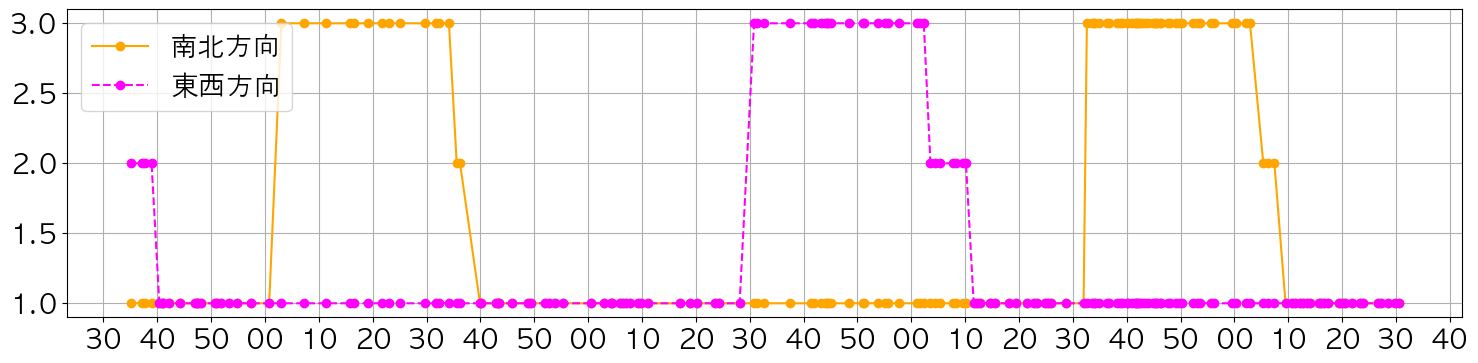

In [128]:
import matplotlib.pyplot as plt; import matplotlib.ticker as ticker

x=[];y1=[];y2=[]
for pics_info in pics_info_list:
    if pics_info['message_type']==2:
        x.append(pics_info['datetime'])
        signal_state=pics_info['pedestrian_signals'][0]['signal_state']
        y1.append({'NoSignal':0,'Red':1,'BlinkGreen':2,'Green':3,'None':4}.get(signal_state))
        signal_state=pics_info['pedestrian_signals'][1]['signal_state']
        y2.append({'NoSignal':0,'Red':1,'BlinkGreen':2,'Green':3,'None':4}.get(signal_state))
plt.figure(figsize=(18,4)) # 散布図の作成
plt.plot(x, y1, label='南北方向', color='orange',marker='o',)
plt.plot(x, y2, label='東西方向', color='magenta',marker='o', linestyle='--')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%S'))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(
    timedelta(seconds=10).total_seconds()/(24*3600)))
plt.legend(loc="upper left"); plt.grid(True, which='both'); plt.show()

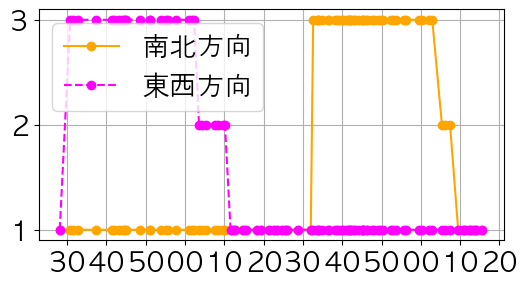

In [141]:
# 図版挿入用画像作成用

import matplotlib.pyplot as plt; import matplotlib.ticker as ticker

x=[];y1=[];y2=[]
for pics_info in pics_info_list[120:-30]:
    if pics_info['message_type']==2:
        x.append(pics_info['datetime'])
        signal_state=pics_info['pedestrian_signals'][0]['signal_state']
        y1.append({'NoSignal':0,'Red':1,'BlinkGreen':2,'Green':3,'None':4}.get(signal_state))
        signal_state=pics_info['pedestrian_signals'][1]['signal_state']
        y2.append({'NoSignal':0,'Red':1,'BlinkGreen':2,'Green':3,'None':4}.get(signal_state))
plt.figure(figsize=(6,3)) # 散布図の作成
plt.plot(x, y1, label='南北方向', color='orange',marker='o',)
plt.plot(x, y2, label='東西方向', color='magenta',marker='o', linestyle='--')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%S'))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(
    timedelta(seconds=10).total_seconds()/(24*3600)))
plt.legend(loc="upper left"); plt.grid(True, which='both'); plt.show()

In [ ]:
# 記事解説図面用

import struct;import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def process_pics(data):
    pics_info = {}
    msg_type=data[2] # 2:メッセージタイプ:0,1,2
    pics_info['message_type'] = msg_type 
    pics_info['message_id'] = data[3] # 3:連番ID
    pics_info['intersection_id'] = \
      "".join([hex(num)[2:].upper().zfill(2) for num in data[6:10]]) # 交差点ID
    if msg_type == 0:   # ========= タイプ0: 識別情報
        if data[10:10+14]==[85,84,77,83,95,80,73,67,83,48,48,48,49,0]:
            pics_info['is_valid_identifier'] = "UTMS_PICS0001"
    elif msg_type == 1: # ========= タイプ1: 位置情報
        pics_info['latitude']=struct.unpack('>i',bytes(data[10:14]))[0]/1000000.0
        pics_info['longitude']=struct.unpack('>i',bytes(data[14:18]))[0]/1000000.0
    elif msg_type == 2: # ========= タイプ2: 信号状態情報
        pedestrian_signals = []
        for i in range(6): # 10,11,12,13,14,15:最大6つまでの歩行者信号の状態
            signal_byte = data[10 + i]
            remaining_time = int( (signal_byte  >> 4) & 0x0F )# 上位4ビット:残り時間          
            signal_state = int(signal_byte  & 0x0F)           # 下位4ビット:信号状態
            signal_info = {
                'remaining_time': -1 if remaining_time >= 8 else remaining_time + 1,
                'signal_state':{0:'NoSignal',1:'Red',2:'BlinkGreen',3:'Green',4:'None'
                }.get(signal_state, 'Unknown')};pedestrian_signals.append(signal_info)
        pics_info['pedestrian_signals'] = pedestrian_signals
    return pics_info

pics_info_list=[]
for manufacturer_data in manufacturer_data_list:
    company_id=list(manufacturer_data.keys())[0]
    if company_id == '0x01CE':# 'HOUWA SYSTEM DESIGN, k.k.'
        pics_info=process_pics(manufacturer_data[company_id])
        pics_info['datetime']=manufacturer_data['datetime']
        pics_info_list.append(pics_info)
x=[];y1=[];y2=[]
for pics_info in pics_info_list:
    if pics_info['message_type']==2:
        x.append(pics_info['datetime'])
        signal_state=pics_info['pedestrian_signals'][0]['signal_state']
        y1.append({'NoSignal':0,'Red':1,'BlinkGreen':2,'Green':3,'None':4}.get(signal_state))
        signal_state=pics_info['pedestrian_signals'][1]['signal_state']
        y2.append({'NoSignal':0,'Red':1,'BlinkGreen':2,'Green':3,'None':4}.get(signal_state))
plt.figure(figsize=(18,4)) # 散布図の作成
plt.plot(x, y1, label='南北方向', color='orange',marker='o',)
plt.plot(x, y2, label='東西方向', color='magenta',marker='o', linestyle='--')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%S'))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(
    timedelta(seconds=10).total_seconds()/(24*3600)))
plt.legend(loc="upper left"); plt.grid(True, which='both'); plt.show()



## 交差点情報を手に入れる

In [146]:
# これが最新

import overpy;import math;from geopy.distance import geodesic

def calculate_way_length(way): # Wayのジオメトリから長さを計算(m)
    total_length = 0; nodes = way.nodes
    for i in range(len(nodes)-1): #各ノード間の距離を足していく
        total_length+=geodesic((nodes[i].lat,nodes[i].lon),
                    (nodes[i+1].lat,nodes[i+1].lon)).meters
    return total_length

def get_nearest_crossing(lat,lon,direction,radius=50):
    direction_angles = {'N':0,'S':180,'E':90,'W':270}
    target_angle=direction_angles.get(direction.upper())
    query = f"""[out:json];(way["highway"="footway"]
    ["footway"="crossing"](around:{radius},{lat},{lon});
    );(._;>;); out geom;""" # NodeとWayを取得
    min_distance=float('inf')
    for way in overpy.Overpass().query(query).ways:
        if not way.nodes or len(way.nodes) < 2:
            continue  # ノードが不足している場合はスキップ
        avg_lat = sum(float(node.lat) for node in way.nodes) / len(way.nodes)
        avg_lon = sum(float(node.lon) for node in way.nodes) / len(way.nodes)
        distance=geodesic((lat,lon),(avg_lat,avg_lon)).meters # 指定位置間距離
        angle = math.degrees(math.atan2(avg_lon-lon,avg_lat-lat))%360 # 方向
        if min((angle - target_angle) % 360, (target_angle - angle)%360)>45:
            continue  # 方向の許容範囲（±45度）でなければスキップ
        total_distance=calculate_way_length(way)+2*2  # wayの長さ+両端2m追加
        if distance < min_distance:
            min_distance=distance; distance_meters=total_distance
    return distance_meters
# 四条堀川西詰北側から東向き
distance = get_nearest_crossing(35.003837502, 135.751655473,"E")
print(f"距離: {int(distance)} m",f"青点灯時間: {int(distance+10)} 秒")

距離: 40 m 青点灯時間: 50 秒
